# Filtered Type Analysis
The GENIA dataset used in many NER papers, including the DyGIE++ paper, is reduced to only 5 of the original 47 entity mention types: DNA, RNA, Protein, Cell Line, and Cell Type. This explains much of the unexpected poor performance of the GENIA model; the model performs exceptionally well on the DNA, RNA and Protein types, and our PICKLE dataset doesn't have many Cell annotations at all. Here, we examine the effect of the types present in training vs. those present at evaluation in order to determine the effect that introducing new types has on a model. We do this by filtering down the PICKLE test set to just types present in the model for each of the biological models, using a messy mapping, and leaving the computer science model (SciERC) out of this analysis. We perform this filtering using the script `filter_dataset.py` in the `annotation/abstract_scripts` directory.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ast import literal_eval
import numpy as np
import jsonlines
from os.path import abspath
from collections import Counter
import json

## Reading in data
### Performance data
First, let's read in the original performance data:

In [98]:
orig_perf_seedev = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/17Jul2023_seedev_on_pickle_performance_no_labels.csv')
orig_perf_all = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/15Jul2023_all_on_pickle_no_seedev_performance.csv')
orig_perf_all = pd.concat([orig_perf_seedev, orig_perf_all])
orig_perf_all['model'] = orig_perf_all['pred_file'].str.split('_').str[-2]
orig_perf_all = orig_perf_all.drop(index=1).reset_index(drop=True)
orig_perf_all

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,17Jul2023_seedev_on_pickle_PICKLE_250_abstract...,PICKLE_250_abstracts_entities_and_relations_FI...,0.373344,0.314438,0.340887,0.167352,0.066984,0.094928,"(0.31789976918733104, 0.4304071630210769)","(0.26929228179228176, 0.35934436835687483)","(0.29586052643654476, 0.3803187764879307)","(0.04750056420672534, 0.349972186904005)","(0.017564797672573393, 0.14164540816326524)","(0.0264594334393325, 0.19697090527267153)",seedev
1,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.883557,0.891106,0.887275,0.608037,0.348510,0.442015,"(0.857079027355623, 0.9084136564951275)","(0.8753625636815292, 0.9081251757571311)","(0.8689741295964972, 0.9057122261710511)","(0.5372982621414583, 0.685561797752809)","(0.27739304532720793, 0.41112138949349963)","(0.37580711361156444, 0.49925964546402507)",pickle
2,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.478968,0.674144,0.559745,0.057466,0.086344,0.068621,"(0.43032869912059807, 0.5308687868236084)","(0.6406513153003568, 0.7108491030638333)","(0.5190181925003347, 0.6002697495183045)","(0.03457632090684005, 0.08541554231822657)","(0.057188308886971524, 0.12067924528301884)","(0.044473370023383384, 0.09702656546489562)",scierc
3,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.557187,0.196518,0.289868,NaN,NaN,NaN,"(0.4912152530292231, 0.6242472804972805)","(0.1523317471518495, 0.24312158926383784)","(0.23576190476190473, 0.3419524854981555)",NaN,NaN,NaN,genia
4,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.589271,0.377282,0.459691,0.118089,0.023735,0.039048,"(0.5134214210792485, 0.6597671470822966)","(0.31619556173564173, 0.4429260106656407)","(0.3932587830568571, 0.5283259376302464)","(0.04967592592592593, 0.20930232558139536)","(0.007501830573391912, 0.04328817733990146)","(0.013247961852022767, 0.06758396923631556)",chemprot
5,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.478597,0.656190,0.553169,0.072374,0.089572,0.079652,"(0.4294379741252424, 0.5316811214758135)","(0.6164612612449871, 0.691908914545175)","(0.5141514693449252, 0.5977567158569393)","(0.03612494415231811, 0.11568160175684078)","(0.04887108610567514, 0.13172888094778185)","(0.042886436544521116, 0.1180061037639878)",scierc-lightweight
6,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.570708,0.160570,0.249894,NaN,NaN,NaN,"(0.49902699456975774, 0.643936419763142)","(0.11667512308468143, 0.20724809293513485)","(0.19321837835989722, 0.3061844812816278)",NaN,NaN,NaN,genia-lightweight


Then let's read in the performance data for the filtered PICKLE test sets:

In [99]:
chem_filt = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/chemprot_filtered_to_chemprot_one_to_many_26Oct2023.csv')
chem_filt['model'] = chem_filt['pred_file'].str.split('_').str[-2]
chem_filt

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.550976,0.646711,0.594586,0.118427,0.023984,0.039371,"(0.46321412552629504, 0.6328108754418797)","(0.5788633993743483, 0.7112573832340332)","(0.5192296982012493, 0.6652737821198854)","(0.04648268398268399, 0.2043749999999998)","(0.007424869037772263, 0.04332909216723586)","(0.013081918081918081, 0.06787456049064945)",chemprot


In [100]:
seed_filt = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/seedev_filtered_to_seedev_25Oct2023.csv')
seed_filt['model'] = seed_filt['pred_file'].str.split('_').str[-2]
seed_filt

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,17Jul2023_seedev_on_pickle_PICKLE_250_abstract...,PICKLE_250_abstracts_entities_and_relations_FI...,0.328247,0.340461,0.333801,0.168889,0.069219,0.097491,"(0.26871289213981975, 0.39050110132158583)","(0.29135568616343294, 0.3865371758814288)","(0.2829620364579714, 0.3786805847837389)","(0.05109840751327072, 0.36505400540054)","(0.01974191345074889, 0.1480144770667027)","(0.02798724656638326, 0.21120129870129856)",seedev


In [101]:
# Pull GENIA form previous version performance
all_models_on_filtered_without_types = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/all_models_on_filtered_genia_11Aug2023_with_cells_bootstrapped.csv')
all_models_on_filtered_without_types['model'] = all_models_on_filtered_without_types['pred_file'].str.split('_').str[-2]
all_models_on_filtered_without_types
genia_filt = all_models_on_filtered_without_types.drop(index=[0,1,2,3,5,6]).reset_index(drop=True)
genia_filt

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.429054,0.657937,0.518286,NaN,NaN,NaN,"(0.337121662168154, 0.5116045101292872)","(0.593459706232632, 0.7142857142857143)","(0.4347237960339943, 0.5841851482252541)",NaN,NaN,NaN,genia
1,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.492113,0.608679,0.543144,NaN,NaN,NaN,"(0.3949423956232654, 0.5804834148884966)","(0.5424804882929758, 0.6684288537549407)","(0.4641350805876706, 0.6073907982509812)",NaN,NaN,NaN,genia-lightweight


Combine all filtered performances:

In [102]:
filtered_perfs = pd.concat([seed_filt, chem_filt, genia_filt, pd.DataFrame(orig_perf_all.iloc[1,:]).T])
filtered_perfs = filtered_perfs.reset_index(drop=True)
filtered_perfs

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,17Jul2023_seedev_on_pickle_PICKLE_250_abstract...,PICKLE_250_abstracts_entities_and_relations_FI...,0.328247,0.340461,0.333801,0.168889,0.069219,0.097491,"(0.26871289213981975, 0.39050110132158583)","(0.29135568616343294, 0.3865371758814288)","(0.2829620364579714, 0.3786805847837389)","(0.05109840751327072, 0.36505400540054)","(0.01974191345074889, 0.1480144770667027)","(0.02798724656638326, 0.21120129870129856)",seedev
1,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.550976,0.646711,0.594586,0.118427,0.023984,0.039371,"(0.46321412552629504, 0.6328108754418797)","(0.5788633993743483, 0.7112573832340332)","(0.5192296982012493, 0.6652737821198854)","(0.04648268398268399, 0.2043749999999998)","(0.007424869037772263, 0.04332909216723586)","(0.013081918081918081, 0.06787456049064945)",chemprot
2,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.429054,0.657937,0.518286,NaN,NaN,NaN,"(0.337121662168154, 0.5116045101292872)","(0.593459706232632, 0.7142857142857143)","(0.4347237960339943, 0.5841851482252541)",NaN,NaN,NaN,genia
3,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.492113,0.608679,0.543144,NaN,NaN,NaN,"(0.3949423956232654, 0.5804834148884966)","(0.5424804882929758, 0.6684288537549407)","(0.4641350805876706, 0.6073907982509812)",NaN,NaN,NaN,genia-lightweight
4,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.883557,0.891106,0.887275,0.608037,0.34851,0.442015,"(0.857079027355623, 0.9084136564951275)","(0.8753625636815292, 0.9081251757571311)","(0.8689741295964972, 0.9057122261710511)","(0.5372982621414583, 0.685561797752809)","(0.27739304532720793, 0.41112138949349963)","(0.37580711361156444, 0.49925964546402507)",pickle


## Performance plots
Let's take a look at the performance differences across conditions:

In [103]:
orig_perf_all = orig_perf_all.sort_values('ent_F1')
orig_perf_all = orig_perf_all.reset_index(drop=True)

In [104]:
def process_ent_only_CIs(df, kind='F1'):
    """
    literal_evals the CI strings in a given dfs.
    """
    ent_CIs = df[f"ent_{kind}_CI"].apply(lambda x: literal_eval(str(x)))
    ent_CIs = pd.DataFrame([[df[f'ent_{kind}'][i] - val[0] for i, val in enumerate(ent_CIs)], [val[1] - df[f'ent_{kind}'][i] for i, val in enumerate(ent_CIs)]])

    return ent_CIs

In [105]:
filtered_perfs

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,17Jul2023_seedev_on_pickle_PICKLE_250_abstract...,PICKLE_250_abstracts_entities_and_relations_FI...,0.328247,0.340461,0.333801,0.168889,0.069219,0.097491,"(0.26871289213981975, 0.39050110132158583)","(0.29135568616343294, 0.3865371758814288)","(0.2829620364579714, 0.3786805847837389)","(0.05109840751327072, 0.36505400540054)","(0.01974191345074889, 0.1480144770667027)","(0.02798724656638326, 0.21120129870129856)",seedev
1,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.550976,0.646711,0.594586,0.118427,0.023984,0.039371,"(0.46321412552629504, 0.6328108754418797)","(0.5788633993743483, 0.7112573832340332)","(0.5192296982012493, 0.6652737821198854)","(0.04648268398268399, 0.2043749999999998)","(0.007424869037772263, 0.04332909216723586)","(0.013081918081918081, 0.06787456049064945)",chemprot
2,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.429054,0.657937,0.518286,NaN,NaN,NaN,"(0.337121662168154, 0.5116045101292872)","(0.593459706232632, 0.7142857142857143)","(0.4347237960339943, 0.5841851482252541)",NaN,NaN,NaN,genia
3,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.492113,0.608679,0.543144,NaN,NaN,NaN,"(0.3949423956232654, 0.5804834148884966)","(0.5424804882929758, 0.6684288537549407)","(0.4641350805876706, 0.6073907982509812)",NaN,NaN,NaN,genia-lightweight
4,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.883557,0.891106,0.887275,0.608037,0.34851,0.442015,"(0.857079027355623, 0.9084136564951275)","(0.8753625636815292, 0.9081251757571311)","(0.8689741295964972, 0.9057122261710511)","(0.5372982621414583, 0.685561797752809)","(0.27739304532720793, 0.41112138949349963)","(0.37580711361156444, 0.49925964546402507)",pickle


In [106]:
all_no_filter_ent_CIs = process_ent_only_CIs(orig_perf_all)
filter_ent_CIs = process_ent_only_CIs(filtered_perfs)

In [107]:
x_dict = {mod:i for i,mod in enumerate(orig_perf_all["model"].values.tolist())}
orig_perf_all["x"] = orig_perf_all["model"].map(x_dict)
filtered_perfs["x"] = filtered_perfs["model"].map(x_dict)

In [108]:
orig_label_key = {'chemprot': 'ChemProt',
         'scierc': 'SciERC',
         'bioinfer': 'BioInfer',
         'genia': 'GENIA',
         'pickle': 'PICKLE',
         'scierc-lightweight': 'SciERC\nLightweight',
         'genia-lightweight': 'GENIA\nLightweight',
         'ace05-relation': 'ACE05',
         'seedev': 'SeeDev'}

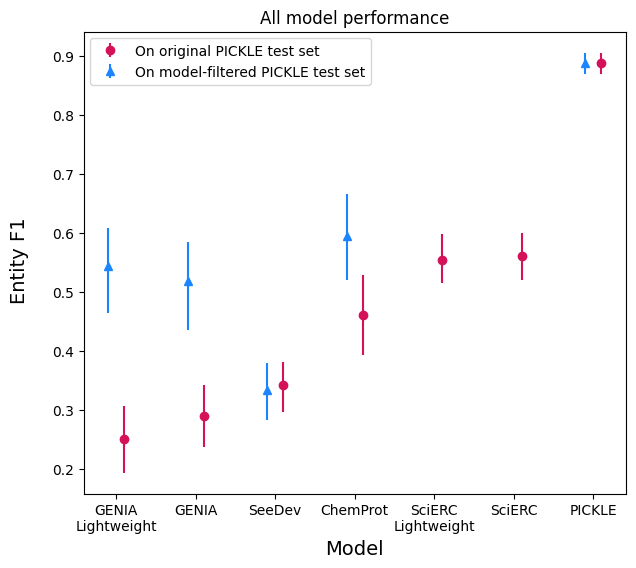

In [109]:
fig, axs = plt.subplots(1, 1, figsize=(7, 6), sharey=True)

name_x = [orig_label_key[mod] for mod in orig_perf_all["model"]]

axs.errorbar(x=orig_perf_all["x"] + 0.1, y=orig_perf_all["ent_F1"], yerr=all_no_filter_ent_CIs, fmt="o", color='#D41159', label='On original PICKLE test set')
axs.errorbar(x=filtered_perfs["x"] - 0.1, y=filtered_perfs["ent_F1"], yerr=filter_ent_CIs, fmt="^", color='#1A85FF', label='On model-filtered PICKLE test set')

axs.set_xticks(orig_perf_all["x"], name_x, size=10, ha='center')
axs.set_xlabel('Model', size=14)
axs.set_title('All model performance')
axs.legend()

fig.supylabel('Entity F1', size=14)
# fig.subplots_adjust(left=0.07)
plt.savefig('../data/straying_off_topic_data/model_performance/genia_filtered_performance_F1.png', format='png', bbox_inches='tight', dpi=600)

We also want to look at the precision and recall for these models:

In [110]:
all_no_filter_ent_CIs_precision = process_ent_only_CIs(orig_perf_all, kind='precision')
filter_ent_CIs_precision = process_ent_only_CIs(filtered_perfs, kind='precision')
all_no_filter_ent_CIs_recall = process_ent_only_CIs(orig_perf_all, kind='recall')
filter_ent_CIs_recall = process_ent_only_CIs(filtered_perfs, kind='recall')

In [111]:
filter_ent_CIs_recall

,0,1,2,3,4
0,0.049106,0.067848,0.064477,0.066199,0.015743
1,0.046076,0.064546,0.056349,0.059750,0.017019


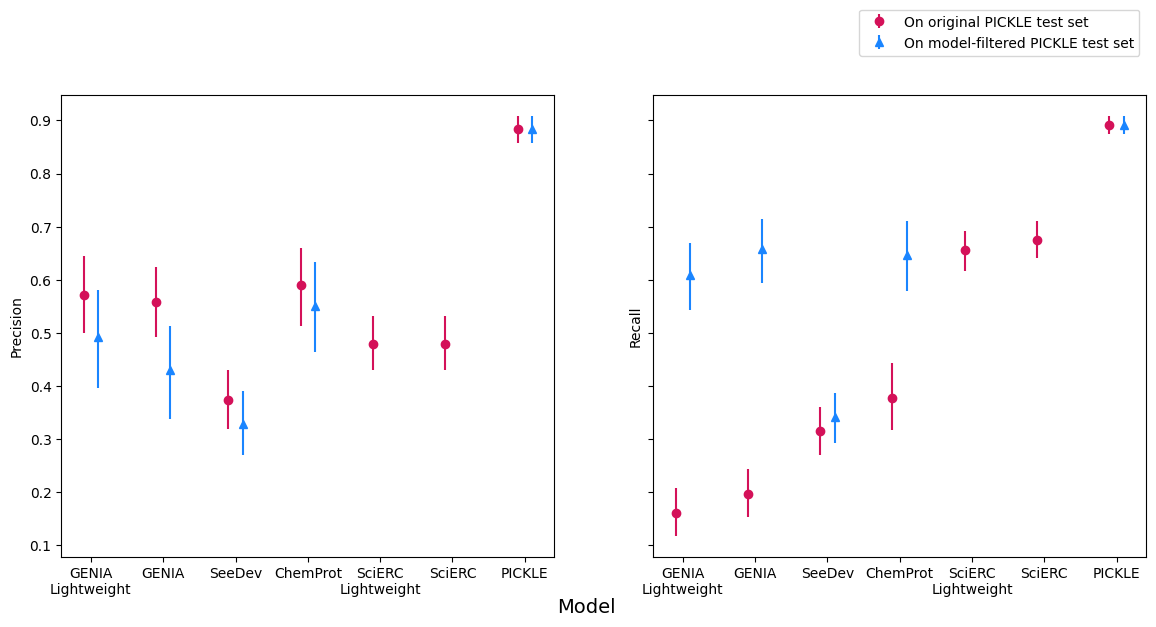

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True, sharex=True)

name_x = [orig_label_key[mod] for mod in orig_perf_all["model"]]

axs[0].errorbar(x=orig_perf_all['x'] - 0.1, y=orig_perf_all['ent_precision'], yerr=all_no_filter_ent_CIs_precision, fmt='o', color='#D41159', label='On original PICKLE test set')
axs[0].errorbar(x=filtered_perfs['x'] + 0.1, y=filtered_perfs['ent_precision'], yerr=filter_ent_CIs_precision, fmt='^', color='#1A85FF', label='On model-filtered PICKLE test set')

axs[0].set_xticks(orig_perf_all['x'], name_x, size=10, ha='center')
axs[0].set_ylabel('Precision')


axs[1].errorbar(x=orig_perf_all['x'] - 0.1, y=orig_perf_all['ent_recall'], yerr=all_no_filter_ent_CIs_recall, fmt='o', color='#D41159', label='On original PICKLE test set')
axs[1].errorbar(x=filtered_perfs['x'] + 0.1, y=filtered_perfs['ent_recall'], yerr=filter_ent_CIs_recall, fmt='^', color='#1A85FF', label='On model-filtered PICKLE test set')

axs[1].set_xticks(orig_perf_all['x'], name_x, size=10, ha='center')
axs[1].set_ylabel('Recall')

axs[1].legend(bbox_to_anchor=(1, 1.2))

fig.supxlabel('Model', size=14)

plt.savefig('../data/straying_off_topic_data/model_performance/filtered_vs_not_precision_and_recall_F1.png', format='png', bbox_inches='tight', dpi=600)

### Mismatch analysis
We need a little more context to understand what's going on with ChemProt here.

In [113]:
chem_mis_filt = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/chemprot_filtered_to_chemprot_26Oct2023_with_mismatch_MISMATCHES.csv')
chem_mis_orig = pd.read_csv('../data/straying_off_topic_data/model_output/mismatch_analysis/all_on_pickle_08Aug2023_with_mismatches_MISMATCHES.csv')
chem_mis_orig = chem_mis_orig[chem_mis_orig['model'] == '/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-corpus-code/data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/model_predictions/15Jul2023_on_pickle_PICKLE_250_abstracts_entities_and_relations_FINAL_05Jul2023_CORRECTED_TEST_no_gold_chemprot_predictions.jsonl']

In [114]:
chem_mis_filt.head()

,doc_key,mismatch_type,sent_num,gold_ent_list,gold_ent_type,pred_ent_list,pred_ent_type,model
0,PMID10549554_abstract,2,0,NaN,NaN,"[1, 1, 'chemical', 13.7819, 1.0]",chemical,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
1,PMID10549554_abstract,2,0,NaN,NaN,"[20, 20, 'chemical', 13.8192, 1.0]",chemical,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
2,PMID10549554_abstract,1,1,"[56, 56, 'organic_compound_other']",organic_compound_other,"[56, 56, 'chemical', 15.6495, 1.0]",chemical,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
3,PMID10549554_abstract,2,2,NaN,NaN,"[64, 65, 'chemical', 25.7052, 1.0]",chemical,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...
4,PMID10549554_abstract,2,2,NaN,NaN,"[71, 71, 'chemical', 17.2749, 1.0]",chemical,/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-c...


0 is a false negative, 1 is a true positive, 2 is a false positive. How do these change between the models?

In [115]:
mis_counts_orig = Counter(chem_mis_orig['mismatch_type'].tolist())
mis_counts_filt = Counter(chem_mis_filt['mismatch_type'].tolist())

In [116]:
mis_counts_orig, mis_counts_filt

(Counter({2: 321, 0: 754, 1: 457}), Counter({2: 645, 1: 133, 0: 79}))

In [117]:
mis_perc_orig = {k: v/sum(mis_counts_orig.values()) for k, v in mis_counts_orig.items()}
mis_perc_filt = {k: v/sum(mis_counts_filt.values()) for k, v in mis_counts_filt.items()}

In [118]:
mis_perc_orig, mis_perc_filt

({2: 0.20953002610966057, 0: 0.49216710182767626, 1: 0.2983028720626632},
 {2: 0.7526254375729288, 1: 0.15519253208868145, 0: 0.09218203033838973})

What are the proportions of PICKLE types that are correctly identified by the ChemProt model and fall under the Chemicals label?

In [119]:
tps = chem_mis_orig[(chem_mis_orig['mismatch_type'] == 1) & (chem_mis_orig['pred_ent_type'] == 'CHEMICAL')]
tps.groupby('gold_ent_type').count()

,doc_key,mismatch_type,sent_num,gold_ent_list,pred_ent_list,pred_ent_type,model
gold_ent_type,,,,,,,
Amino_acid_monomer,4,4,4,4,4,4,4
DNA,1,1,1,1,1,1,1
Element,12,12,12,12,12,12,12
Inorganic_compound_other,23,23,23,23,23,23,23
Multicellular_organism,1,1,1,1,1,1,1
Organic_compound_other,80,80,80,80,80,80,80
Peptide,1,1,1,1,1,1,1
Plant_hormone,162,162,162,162,162,162,162
Protein,1,1,1,1,1,1,1


In [143]:
tps = chem_mis_orig[(chem_mis_orig['mismatch_type'] == 1) & (chem_mis_orig['pred_ent_type'] == 'GENE')]
tps.groupby('gold_ent_type').count()

,doc_key,mismatch_type,sent_num,gold_ent_list,pred_ent_list,pred_ent_type,model
gold_ent_type,,,,,,,
DNA,51,51,51,51,51,51,51
Multicellular_organism,16,16,16,16,16,16,16
Organic_compound_other,1,1,1,1,1,1,1
Plant_hormone,5,5,5,5,5,5,5
Protein,94,94,94,94,94,94,94
RNA,1,1,1,1,1,1,1
Virus,1,1,1,1,1,1,1


I've gone back and added the extra types that are under the Chemicals header to the analysis, and will now redo the above figures with that version. We can also look at the TP/FP/FN proportions with this new version:

In [121]:
chem_mis_filt_many = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/chemprot_filtered_to_chemprot_one_to_many_26Oct2023_with_mismatches_MISMATCHES.csv')

In [122]:
mis_counts_filt_many = Counter(chem_mis_filt_many['mismatch_type'].tolist())

In [123]:
mis_perc_filt_many = {k: v/sum(mis_counts_filt_many.values()) for k, v in mis_counts_filt_many.items()}

In [124]:
mis_perc_filt_many

{2: 0.34489593657086226, 1: 0.4261645193260654, 0: 0.22893954410307235}

## Proportions of predicted types
We never actually looked at what the proportions of types are in the *predictions* for the out of domain models. We are specifically interested in knowing if SciERC's predictions are dominated by OtherScientificTerm. Let's take a look:

In [125]:
model_preds = {
    'scierc': '../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/model_predictions/15Jul2023_on_pickle_PICKLE_250_abstracts_entities_and_relations_FINAL_05Jul2023_CORRECTED_TEST_no_gold_scierc_predictions.jsonl',
    'seedev': '../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/model_predictions/17Jul2023_seedev_on_pickle_PICKLE_250_abstracts_entities_and_relations_FINAL_05Jul2023_CORRECTED_TEST_no_gold_seedev_predictions.jsonl'
    }

In [126]:
with jsonlines.open(abspath(model_preds['scierc'])) as reader:
    pred_list = []
    for obj in reader:
        pred_list.append(obj)
pred_types = []
for doc in pred_list:
    for sent in doc['predicted_ner']:
        for ent in sent:
            pred_types.append(ent[2])

In [127]:
scierc_pred_counts = Counter(pred_types)
scierc_pred_counts

Counter({'Method': 352,
         'Task': 242,
         'Material': 128,
         'OtherScientificTerm': 862,
         'Metric': 45,
         'Generic': 71})

In [128]:
scierc_pred_counts['OtherScientificTerm']/len(pred_types)

0.5070588235294118

In [144]:
scierc_pred_counts['Generic']/len(pred_types)

0.06981317600786627

In [145]:
scierc_pred_counts['Material']/len(pred_types)

0.12586037364798427

What proportion of the true positives belong to each of these categories?

In [147]:
scierc_orig_mis = pd.read_csv('../data/straying_off_topic_data/model_performance/scierc_mismatch_on_full_pick_26Oct2023_MISMATCHES.csv')

In [151]:
scierc_orig_mis['model'].unique()

array(['/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-corpus-code/data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/model_predictions/15Jul2023_on_pickle_PICKLE_250_abstracts_entities_and_relations_FINAL_05Jul2023_CORRECTED_TEST_no_gold_scierc_predictions.jsonl',
       '/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-corpus-code/data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/model_predictions/15Jul2023_on_pickle_PICKLE_250_abstracts_entities_and_relations_FINAL_05Jul2023_CORRECTED_TEST_no_gold_scierc-lightweight_predictions.jsonl'],
      dtype=object)

In [152]:
scierc_orig_mis = scierc_orig_mis[scierc_orig_mis['model'] == '/mnt/ufs18/home-118/lotrecks/Shiu_lab/pickle-corpus-code/data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/model_predictions/15Jul2023_on_pickle_PICKLE_250_abstracts_entities_and_relations_FINAL_05Jul2023_CORRECTED_TEST_no_gold_scierc_predictions.jsonl']

In [153]:
tps = scierc_orig_mis[scierc_orig_mis['mismatch_type'] == 1]
tps.groupby('pred_ent_type').count()

,doc_key,mismatch_type,sent_num,gold_ent_list,gold_ent_type,pred_ent_list,model
pred_ent_type,,,,,,,
generic,3,3,3,3,3,3,3
material,91,91,91,91,91,91,91
method,231,231,231,231,231,231,231
metric,18,18,18,18,18,18,18
otherscientificterm,396,396,396,396,396,396,396
task,76,76,76,76,76,76,76


In [156]:
tps.shape

(815, 8)

In [157]:
396/815

0.48588957055214727

In [158]:
231/815

0.28343558282208586

In [163]:
other = scierc_orig_mis[(scierc_orig_mis['mismatch_type'] == 1) & (scierc_orig_mis['pred_ent_type'] == 'otherscientificterm')]
method = scierc_orig_mis[(scierc_orig_mis['mismatch_type'] == 1) & (scierc_orig_mis['pred_ent_type'] == 'method')]

In [165]:
other.groupby('gold_ent_type').count()

,doc_key,mismatch_type,sent_num,gold_ent_list,pred_ent_list,pred_ent_type,model
gold_ent_type,,,,,,,
amino_acid_monomer,3,3,3,3,3,3,3
biochemical_pathway,3,3,3,3,3,3,3
biochemical_process,64,64,64,64,64,64,64
cell,1,1,1,1,1,1,1
dna,40,40,40,40,40,40,40
element,5,5,5,5,5,5,5
inorganic_compound_other,20,20,20,20,20,20,20
multicellular_organism,28,28,28,28,28,28,28
organic_compound_other,57,57,57,57,57,57,57


In [170]:
other_props = other.groupby('gold_ent_type').count()['doc_key'] / len(other)
other_props

gold_ent_type
amino_acid_monomer          0.007576
biochemical_pathway         0.007576
biochemical_process         0.161616
cell                        0.002525
dna                         0.101010
element                     0.012626
inorganic_compound_other    0.050505
multicellular_organism      0.070707
organic_compound_other      0.143939
plant_hormone               0.297980
plant_region                0.007576
protein                     0.123737
rna                         0.007576
unicellular_organism        0.002525
virus                       0.002525
Name: doc_key, dtype: float64

In [166]:
method.groupby('gold_ent_type').count()

,doc_key,mismatch_type,sent_num,gold_ent_list,pred_ent_list,pred_ent_type,model
gold_ent_type,,,,,,,
biochemical_pathway,14,14,14,14,14,14,14
biochemical_process,21,21,21,21,21,21,21
dna,35,35,35,35,35,35,35
element,1,1,1,1,1,1,1
multicellular_organism,31,31,31,31,31,31,31
organic_compound_other,16,16,16,16,16,16,16
plant_hormone,49,49,49,49,49,49,49
protein,56,56,56,56,56,56,56
unicellular_organism,5,5,5,5,5,5,5


In [182]:
method_props = method.groupby('gold_ent_type').count()['doc_key'] / len(method)
method_props

gold_ent_type
biochemical_pathway       0.060606
biochemical_process       0.090909
dna                       0.151515
element                   0.004329
multicellular_organism    0.134199
organic_compound_other    0.069264
plant_hormone             0.212121
protein                   0.242424
unicellular_organism      0.021645
virus                     0.012987
Name: doc_key, dtype: float64

In [183]:
missing = [ i for i in other_props.index if i not in method_props.index]
for m in missing:
    method_props = method_props.append(pd.Series(0.0, index=[m]))
method_props

biochemical_pathway         0.060606
biochemical_process         0.090909
dna                         0.151515
element                     0.004329
multicellular_organism      0.134199
organic_compound_other      0.069264
plant_hormone               0.212121
protein                     0.242424
unicellular_organism        0.021645
virus                       0.012987
amino_acid_monomer          0.000000
cell                        0.000000
inorganic_compound_other    0.000000
plant_region                0.000000
rna                         0.000000
dtype: float64

In [184]:
method_props = method_props.reindex(other_props.index)

In [185]:
to_plot = pd.DataFrame({'Method': method_props, 'OtherScientificTerm': other_props})
to_plot

,Method,OtherScientificTerm
gold_ent_type,,
amino_acid_monomer,0.000000,0.007576
biochemical_pathway,0.060606,0.007576
biochemical_process,0.090909,0.161616
cell,0.000000,0.002525
dna,0.151515,0.101010
element,0.004329,0.012626
inorganic_compound_other,0.000000,0.050505
multicellular_organism,0.134199,0.070707
organic_compound_other,0.069264,0.143939


In [187]:
colors = {
    'biochemical_pathway': '#1F77B4',
 'multicellular_organism': '#AEC7E8',
 'biochemical_process': '#FF7F0E',
 'virus': '#FFBB78',
 'organic_compound_other': '#2CA02C',
 'plant_hormone': '#98DF8A',
 'dna': '#D62728',
 'cell': '#FF9896',
 'protein': '#9467BD',
 'plant_region': '#C5B0D5',
 'inorganic_compound_other': '#8C564B',
 'amino_acid_monomer': '#C49C94',
 'rna': '#E377C2',
 'tissue': '#F7B6D2',
 'peptide': '#7F7F7F',
 'unicellular_organism': '#C7C7C7',
 'element': '#BCBD22'
}

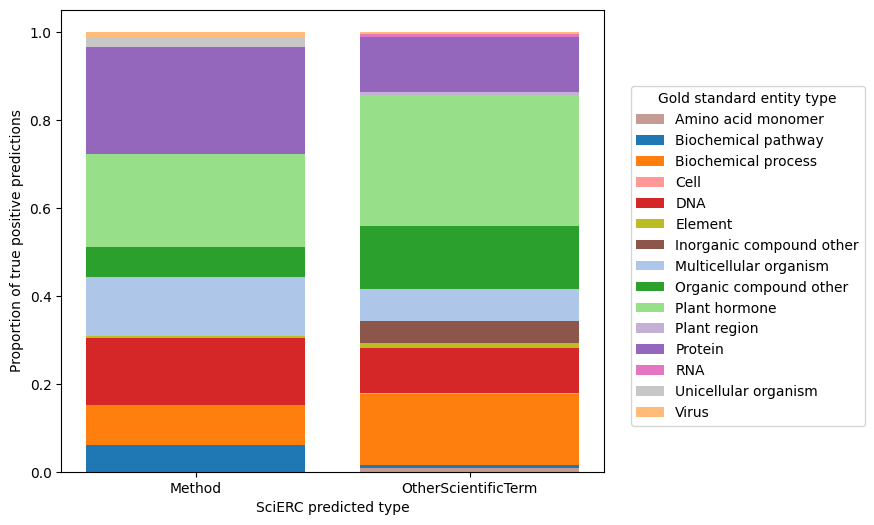

In [203]:
fig, axs = plt.subplots(1, 1, figsize=(7,6))
prev_vals = {'Method': 0, 'OtherScientificTerm': 0}
for typ in to_plot.index:
    color = colors[typ]
    this_ent_x = to_plot.columns
    this_ent_props = to_plot.loc[typ]
    label = ' '.join(typ.split('_')).capitalize() if typ not in ['dna', 'rna'] else typ.upper()
    axs.bar(this_ent_x, this_ent_props, bottom=list(prev_vals.values()), color=color, label=label)
    current_vals = {i: j for i, j in zip(this_ent_x, this_ent_props)}
    prev_vals = {k: prev_vals[k] + v for k, v in current_vals.items()}
fig.canvas.draw()

plt.ylabel('Proportion of true positive predictions')
plt.xlabel('SciERC predicted type')
plt.legend(loc=(1.05, 0.1), title='Gold standard entity type')

plt.savefig('../data/straying_off_topic_data/model_performance/scierc_pred_props.png', format='png', dpi=600, bbox_inches='tight')

We also want to check how many of SeeDev's types are `Environmental_factor` to make sure that it's not a significant portion:

In [129]:
with jsonlines.open(abspath(model_preds['seedev'])) as reader:
    pred_list = []
    for obj in reader:
        pred_list.append(obj)
pred_types = []
for doc in pred_list:
    for sent in doc['predicted_ner']:
        for ent in sent:
            pred_types.append(ent[2])

In [130]:
seedev_pred_counts = Counter(pred_types)
seedev_pred_counts

Counter({'Protein': 136,
         'RNA': 50,
         'Regulatory_Network': 92,
         'Genotype': 194,
         'Pathway': 97,
         'Protein_Family': 50,
         'Gene': 113,
         'Gene_Family': 6,
         'Tissue': 176,
         'Development_Phase': 100,
         'Environmental_Factor': 2,
         'Promoter': 1})

In [204]:
2/sum(seedev_pred_counts.values())

0.0019665683382497543

There are only two predictions in that category in the entire dataset, and it's 0.1% of the total predictions; I think it's okay that they don't map to anything.

We also want to look at the types in the PICKLE gold standard, as the fact that the SeeDev model doesn't improve on filtering implies that it already predicts most of the types that are present in the gold standard. We just want to back that up with fact:

In [131]:
pick_gold = '../data/straying_off_topic_data/unified_annotations_processed/jsonl_files/PICKLE_250_abstracts_entities_and_relations_FINAL_05Jul2023_CORRECTED_TEST.jsonl'
with jsonlines.open(abspath(pick_gold)) as reader:
    pick_gold_list = []
    for obj in reader:
        pick_gold_list.append(obj)
gold_types = []
for doc in pick_gold_list:
    for sent in doc['ner']:
        for ent in sent:
            gold_types.append(ent[2])

In [132]:
pick_counts = Counter(gold_types)
pick_counts

Counter({'Plant_hormone': 218,
         'Biochemical_process': 213,
         'Multicellular_organism': 235,
         'Biochemical_pathway': 37,
         'Protein': 166,
         'DNA': 101,
         'Organic_compound_other': 111,
         'Unicellular_organism': 17,
         'Inorganic_compound_other': 51,
         'RNA': 6,
         'Cell': 3,
         'Tissue': 2,
         'Element': 14,
         'Plant_region': 21,
         'Amino_acid_monomer': 9,
         'Virus': 6,
         'Peptide': 1})

In [133]:
# Read in the map for SeeDev
with open(abspath('../annotation/abstract_scripts/ontology_maps/seeDev_to_PICKLE_entities.json')) as myf:
    seedev_map = json.load(myf)

In [134]:
seedev_mapped = list(set(seedev_map.values()))

What percentage of the gold standard types are covered by those present in the seedev map?

In [135]:
total_covered = 0
for typ in seedev_mapped:
    total_covered += pick_counts[typ]
perc_covered = total_covered/sum(pick_counts.values())
perc_covered

0.8084227910817506

What about the GENIA map?

In [136]:
# Read in the map for GENIA
with open(abspath('../annotation/abstract_scripts/ontology_maps/GENIA_to_PICKLE_entities.json')) as myf:
    genia_map = json.load(myf)

In [137]:
genia_mapped = list(set(genia_map.values()))

In [138]:
total_covered = 0
for typ in genia_mapped:
    total_covered += pick_counts[typ]
perc_covered = total_covered/sum(pick_counts.values())
perc_covered

0.22791081750619324

We can also look at the ChemProt map:

In [139]:
with open(abspath('../annotation/abstract_scripts/ontology_maps/chemprot_to_PICKLE_entities.json')) as myf:
    chemprot_map = json.load(myf)

In [140]:
chemprot_mapped = list(set(chemprot_map['CHEMICAL'] + chemprot_map['GENE'] + [v for k, v in chemprot_map.items() if k not in ['CHEMICAL', 'GENE']]))

In [141]:
total_covered = 0
for typ in chemprot_mapped:
    total_covered += pick_counts[typ]
perc_covered = total_covered/sum(pick_counts.values())
perc_covered

0.5458298926507019

## Table for supplemental
We want to make a pretty formatted table of the performances on the model-filtered test set for the supplemental.

In [12]:
def replace_nan(df):
    """
    Replace a NaN in a CI column with (0,0) to avoid downstream errors.
    """
    idxs = df.index[df['model'].isin(['genia', 'genia-lightweight'])]
    for col_name in ['rel_precision_CI', 'rel_recall_CI', 'rel_F1_CI']:
        for idx in idxs:
            df.loc[idx, col_name] = "(0,0)"
    return df

In [80]:
# Make pretty table for supplemental
label_key = {'chemprot': 'ChemProt',
         'scierc': 'SciERC',
         'bioinfer': 'BioInfer',
         'genia': 'GENIA',
         'pickle': 'PICKLE',
         'scierc-lightweight': 'SciERC lightweight',
         'genia-lightweight': 'GENIA lightweight',
         'ace05-relation': 'ACE05',
         'seedev': 'SeeDev'}

for_table_label_filtered = replace_nan(filtered_perfs).drop(columns=['pred_file', 'gold_std_file', 'x'])
# Map model column to semantic names
for_table_label_filtered = for_table_label_filtered.replace({'model': label_key})
# Combine estimated and their CIs with only 2 decimal points in a single column
cols_to_drop = []
for typ in ['ent', 'rel']:
    semantic_typ = 'Entity'
    for k in ['F1', 'precision', 'recall']:
        if typ == 'rel':
            cols_to_drop.extend([f'{typ}_{k}_CI', f'{typ}_{k}'])
        else:
            cols_to_drop.extend([f'{typ}_{k}_CI', f'{typ}_{k}'])
            semantic_k = 'F1' if k == 'F1' else k.capitalize()
            estimate_col = for_table_label_filtered[f'{typ}_{k}'].astype(float).round(2).replace({np.nan: '--'})
            ci_col = for_table_label_filtered[f'{typ}_{k}_CI']
            ci_col = ci_col.apply(lambda x: ' to '.join([str(round(i, 2)) for i in literal_eval(str(x))])).replace({'0 to 0': ''})
            joiner = pd.Series([', ' if estimate_col[i] != '--' else '' for i in range(len(estimate_col))])
            joined_col = estimate_col.astype(str) + joiner + ci_col
            for_table_label_filtered[f'{semantic_typ} {semantic_k}'] = joined_col
for_table_label_filtered = for_table_label_filtered.rename(columns={'model': 'Model'})
for_table_label_filtered = for_table_label_filtered.drop(columns=cols_to_drop)
for_table_label_filtered

,Model,Entity F1,Entity Precision,Entity Recall
0,SeeDev,"0.33, 0.28 to 0.38","0.33, 0.27 to 0.39","0.34, 0.29 to 0.39"
1,ChemProt,"0.27, 0.17 to 0.37","0.17, 0.1 to 0.25","0.62, 0.48 to 0.74"
2,GENIA,"0.52, 0.43 to 0.58","0.43, 0.34 to 0.51","0.66, 0.59 to 0.71"
3,GENIA lightweight,"0.54, 0.46 to 0.61","0.49, 0.39 to 0.58","0.61, 0.54 to 0.67"
4,PICKLE,"0.89, 0.87 to 0.91","0.88, 0.86 to 0.91","0.89, 0.88 to 0.91"
